In [224]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import acf

import warnings
warnings.filterwarnings("ignore")

In [52]:
path = "../data/interim/groningen_data.csv"

df = pd.read_csv(path)

In [225]:
# Filter single well
df1 = df[df.cat == "FROOMBOSCH-01"][['date', 'gas']]
df1['date'] = pd.to_datetime(df1.date)
df1['month'] = df1.date.dt.month

### Make lag features: 1 month, 12 month
df1['gas_lag_1m'] = df1.gas.shift(1)
df1['gas_lag_12m'] = df1.gas.shift(12)

### Simple moving average (SMA)
df1['sma_6'] = df1['gas'].rolling(window=6).mean()

### Exponential moving average (EMA)
df1['ema_9'] = df1['gas'].ewm(span=9).mean()

### Standard devaiation
df1['std_dev_6'] = df1['gas'].rolling(window=6).std()

### Autocorrelation coefficient
df1['gas_autocorr_lag1'] = acf(df1['gas'], nlags=1)[1]

### Select trend, seasonal and resid
# 1. STL
stl = STL(df1['gas'], period=12).fit()
df1['gas_trend'] = stl.trend
df1['gas_season'] = stl.seasonal
df1['gas_resid'] = stl.resid

# 2. Polynomial smoothing
x = np.arange(len(df1))
y = df1['gas'].values
z = np.polyfit(x, y, deg=7)
p = np.poly1d(z)
df1['gas_trend1'] = p(x)
df1['gas_no_trend1'] = df1['gas'] - df1['gas_trend1']
gas_season1 = df1['gas_no_trend1'].groupby(df1.date.dt.year).mean()
df1['gas_season1'] = gas_season1[df1.date.dt.year].values
df1['gas_resid1'] = df1['gas_no_trend1'] - df1['gas_season1']


# 3. Holt-Winters method
model = ExponentialSmoothing(df1['gas'], trend='additive', seasonal='additive', seasonal_periods=12)
fit = model.fit()
df1['gas_trend2'] = fit.level
df1['gas_season2'] = fit.season
df1['gas_resid2'] = fit.resid

# Filter out 0 data
df1 = df1[df1.gas != 0]

In [226]:
df1

,date,gas,month,gas_lag_1m,gas_lag_12m,sma_6,ema_9,std_dev_6,gas_autocorr_lag1,gas_trend,gas_season,gas_resid,gas_trend1,gas_no_trend1,gas_season1,gas_resid1,gas_trend2,gas_season2,gas_resid2
16693,2003-01-01,31718.129305,1,NaN,NaN,NaN,31718.129305,NaN,0.777254,11912.296686,18236.778505,1569.054114,11344.793086,20373.336219,-1484.547247,21857.883466,15372.737345,14247.124900,12434.949213
16694,2003-02-01,24318.955495,2,31718.129305,NaN,NaN,27607.477188,NaN,0.777254,11368.521851,8217.756551,4732.677093,11213.784570,13105.170925,-1484.547247,14589.718172,17578.451466,6146.688868,3519.123713
16695,2003-03-01,6091.079210,3,24318.955495,NaN,NaN,18789.281296,NaN,0.777254,10839.894254,-981.542016,-3767.273028,11087.268051,-4996.188841,-1484.547247,-3511.641594,8675.872161,-256.309349,-13799.280310
16696,2003-04-01,7123.840995,4,6091.079210,NaN,NaN,14837.573877,NaN,0.777254,10325.250732,-1707.301249,-1494.108488,10965.123183,-3841.282188,-1484.547247,-2356.734941,8918.878469,-1872.699980,460.250908
16697,2003-05-01,6186.021560,5,7123.840995,NaN,NaN,12263.932659,NaN,0.777254,9824.718498,-5604.634644,1965.937706,10847.244849,-4661.223289,-1484.547247,-3176.676042,12123.658928,-6794.440869,5077.670151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16935,2023-03-01,6809.087061,3,1159.689158,7782.789430,3489.242304,3462.282997,2716.568882,0.777254,1649.448564,5684.606084,-524.967586,2168.872609,4640.214453,273.931921,4366.282532,148.912769,6236.127422,2513.026774
16936,2023-04-01,1089.840071,4,6809.087061,7526.074810,3670.638103,2987.794412,2461.456818,0.777254,1503.741384,1551.134618,-1965.035931,2031.685563,-941.845492,273.931921,-1215.777413,-1916.761766,3536.380567,-3139.624944
16937,2023-05-01,145.567721,5,1089.840071,2073.441762,3312.136669,2419.349074,2830.575352,0.777254,1356.818148,-1772.951891,561.701464,1868.166343,-1722.598622,273.931921,-1996.530543,-2816.987993,3185.689012,-1322.353708
16938,2023-06-01,628.793690,6,145.567721,2531.165161,2555.495017,2061.237997,2841.811258,0.777254,1209.900767,-889.842287,308.735211,1675.967011,-1047.173321,273.931921,-1321.105242,-302.847183,256.540275,4000.845177


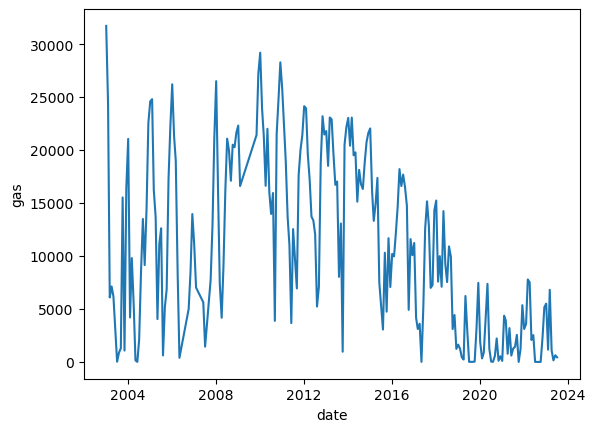

In [227]:
ax = sns.lineplot(data=df1, x='date', y='gas')

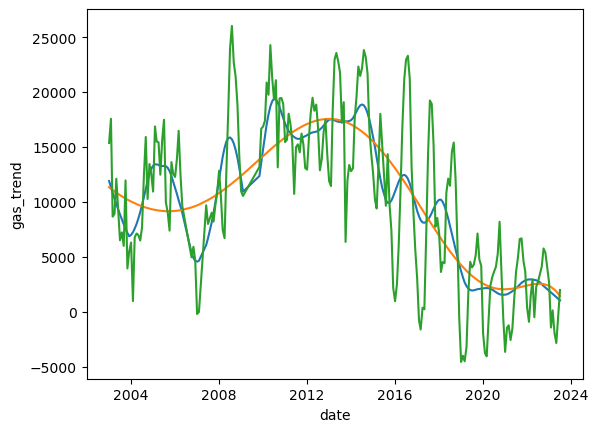

In [228]:
sns.lineplot(data=df1, x='date', y='gas_trend')
sns.lineplot(data=df1, x='date', y='gas_trend1')
sns.lineplot(data=df1, x='date', y='gas_trend2');

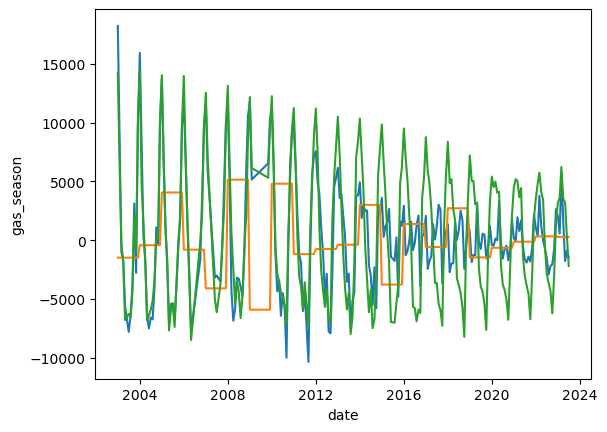

In [229]:
sns.lineplot(data=df1, x='date', y='gas_season')
sns.lineplot(data=df1, x='date', y='gas_season1')
sns.lineplot(data=df1, x='date', y='gas_season2');

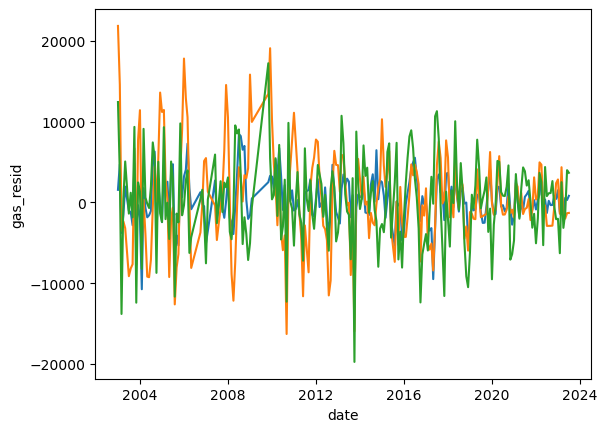

In [230]:
sns.lineplot(data=df1, x='date', y='gas_resid')
sns.lineplot(data=df1, x='date', y='gas_resid1')
sns.lineplot(data=df1, x='date', y='gas_resid2');